# LAI/FAPAR Analysis (Real-Time Dashboard)
This notebook reads your Parquet outputs (local or ADLS via ABFSS), then:
- computes **daily** & **monthly** stats
- builds a **climatology** and **anomalies**
- renders **timeseries** and **spatial hexbin** maps

Use the widgets below to point at your storage and tweak parameters.

In [4]:
# Widgets
dbutils.widgets.text("SECRET_SCOPE", "climate-scope", "Secret Scope")
dbutils.widgets.text("AZURE_ACCOUNT_KEY_NAME", "AZURE_STORAGE_KEY", "Key Secret Name")
dbutils.widgets.text("AZURE_ACCOUNT_NAME_NAME", "AZURE_STORAGE_ACCOUNT", "Account Secret Name")

dbutils.widgets.text("CONTAINER", "climate-data-analysis", "ADLS Container")
dbutils.widgets.text("BASE_DIR", "climate_data/*/*.parquet", "Base Dir/Glob")

dbutils.widgets.text("PARQUET_LOCAL_GLOB", "ClimateRecords/parquet_output/*/*.parquet", "Local Parquet Glob")
dbutils.widgets.dropdown("SOURCE", "adls", ["adls","local"], "Read From")

dbutils.widgets.text("BASELINE_START", "1985", "Climatology Start (year)")
dbutils.widgets.text("BASELINE_END", "2025", "Climatology End (year)")
dbutils.widgets.text("GRID_DEG", "0.10", "Spatial Cell Size (deg)")

dbutils.widgets.dropdown("VARIABLE", "LAI", ["LAI","FAPAR"], "Variable to Focus")

In [6]:
# Setup: secrets, ABFSS conf, imports, widget values
import os
from pyspark.sql import functions as F

SCOPE   = dbutils.widgets.get("SECRET_SCOPE")
ACC_SEC = dbutils.widgets.get("AZURE_ACCOUNT_NAME_NAME")
KEY_SEC = dbutils.widgets.get("AZURE_ACCOUNT_KEY_NAME")

# Pull secrets for ADLS
account = dbutils.secrets.get(SCOPE, ACC_SEC)
key     = dbutils.secrets.get(SCOPE, KEY_SEC)

# Set Spark conf for ABFSS (safe to run even if reading local)
spark.conf.set(f"fs.azure.account.key.{account}.dfs.core.windows.net", key)

CONTAINER = dbutils.widgets.get("CONTAINER")
BASE_DIR  = dbutils.widgets.get("BASE_DIR").strip("/")
SOURCE    = dbutils.widgets.get("SOURCE")
LOCAL_GLOB = dbutils.widgets.get("PARQUET_LOCAL_GLOB")

BASELINE_START = int(dbutils.widgets.get("BASELINE_START"))
BASELINE_END   = int(dbutils.widgets.get("BASELINE_END"))
GRID_DEG       = float(dbutils.widgets.get("GRID_DEG"))
FOCUS_VAR      = dbutils.widgets.get("VARIABLE")

spark.catalog.clearCache()

abfss_glob = f"abfss://{CONTAINER}@{account}.dfs.core.windows.net/{BASE_DIR}"
print("Reading from:", "ADLS" if SOURCE=="adls" else "LOCAL")
print("ABFSS path:", abfss_glob)
print("Local glob:", LOCAL_GLOB)

import matplotlib.pyplot as plt
import pandas as pd

Reading from: ADLS
ABFSS path: abfss://climate-data-analysis@datalakeq7aj6k0.dfs.core.windows.net/climate_data/*/*.parquet
Local glob: ClimateRecords/parquet_output/*/*.parquet


In [7]:
# Loader
# Parquet columns: latitude: double, longitude: double, time: bigint (ms), LAI: double, FAPAR: double
from pyspark.sql import functions as F

def load_lai_fapar_from_parquet(path_glob: str):
    sdf = spark.read.parquet(path_glob)

    # Select only needed columns (present per your schema)
    sdf = sdf.select("latitude", "longitude", "time", "LAI", "FAPAR")

    # Epoch conversion:
    # Convert rows by checking magnitude.
    # (ms > 10^11 roughly; seconds <= 10^11)
    secs = F.when(F.col("time") > F.lit(100_000_000_000), F.col("time")/F.lit(1000.0)).otherwise(F.col("time").cast("double"))
    sdf = sdf.withColumn("time", F.to_timestamp(F.from_unixtime(secs)))

    # Drop null/insane timestamps (prevents "year out of range")
    sdf = sdf.filter(F.col("time").isNotNull())
    # Keep only files dated 1985 and later
    sdf = sdf.filter(F.year("time") >= 1985)
    sdf = sdf.filter(
        (F.col("time") >= F.to_timestamp(F.lit("1980-01-01 00:00:00"))) &
        (F.col("time") <= F.to_timestamp(F.lit("2035-01-01 00:00:00")))
    )

    # Normalize column names for downstream cells
    sdf = (sdf
           .withColumnRenamed("LAI", "lai")
           .withColumnRenamed("FAPAR", "fapar"))

    # Final canonical set
    return sdf.select("latitude", "longitude", "time", "lai", "fapar")

path = abfss_glob if SOURCE == "adls" else LOCAL_GLOB
sdf = load_lai_fapar_from_parquet(path)

In [8]:
from pyspark.sql import functions as F

sdf_check = (sdf
    .withColumn("file_path", F.col("_metadata.file_path"))
    .withColumn("ymd_file",  F.regexp_extract("file_path", r'/CR(\d{8})\.parquet$', 1))
    .withColumn("file_date", F.to_date("ymd_file","yyyyMMdd").cast("date"))
)

per_file_after_loader = (sdf_check
    .groupBy("file_path","file_date")
    .agg(F.count("*").alias("rows_after_loader"))
    .orderBy("rows_after_loader","file_date")
)

display(per_file_after_loader)

# Distinct dates per year (should now show the full 20 if all files have rows in your ROI)
coverage = (sdf_check
    .withColumn("date", F.to_date("time"))
    .groupBy(F.year("date").alias("year"))
    .agg(F.countDistinct("date").alias("num_days"))
    .orderBy("year")
)
display(coverage)

,file_path,file_date,rows_after_loader
0,abfss://climate-data-analysis@datalakeq7aj6k0.dfs.core.windows.net/climate_data/1985/CR19850101.parquet,1985-01-01,1200
1,abfss://climate-data-analysis@datalakeq7aj6k0.dfs.core.windows.net/climate_data/1985/CR19850102.parquet,1985-01-02,1200
2,abfss://climate-data-analysis@datalakeq7aj6k0.dfs.core.windows.net/climate_data/1985/CR19850103.parquet,1985-01-03,1200
3,abfss://climate-data-analysis@datalakeq7aj6k0.dfs.core.windows.net/climate_data/1985/CR19850104.parquet,1985-01-04,1200
4,abfss://climate-data-analysis@datalakeq7aj6k0.dfs.core.windows.net/climate_data/1985/CR19850105.parquet,1985-01-05,1200
5,abfss://climate-data-analysis@datalakeq7aj6k0.dfs.core.windows.net/climate_data/1985/CR19850106.parquet,1985-01-06,1200
6,abfss://climate-data-analysis@datalakeq7aj6k0.dfs.core.windows.net/climate_data/1985/CR19850107.parquet,1985-01-07,1200
7,abfss://climate-data-analysis@datalakeq7aj6k0.dfs.core.windows.net/climate_data/1985/CR19850108.parquet,1985-01-08,1200
8,abfss://climate-data-analysis@datalakeq7aj6k0.dfs.core.windows.net/climate_data/1985/CR19850109.parquet,1985-01-09,1200
9,abfss://climate-data-analysis@datalakeq7aj6k0.dfs.core.windows.net/climate_data/1985/CR19850110.parquet,1985-01-10,1200


,year,num_days
0,1985,30
1,1986,30
2,1987,30
3,1988,30
4,1989,30
5,1990,30
6,1991,30
7,1992,30
8,1993,30
9,1994,30


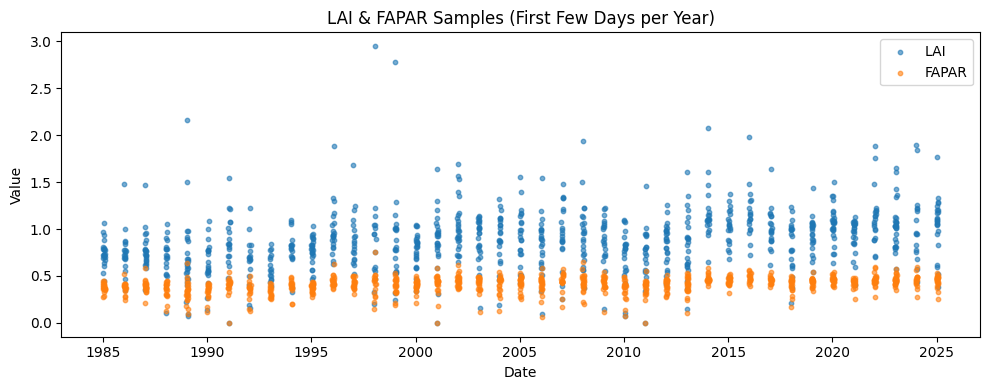

In [9]:
# Daily aggregation (Spark) + plot
daily_sdf = (
    sdf
    .withColumn("date", F.to_date("time"))
    .groupBy("date")
    .agg(
        F.mean("lai").alias("LAI"),
        F.mean("fapar").alias("FAPAR")
    )
    .orderBy("date")
)

daily = daily_sdf.toPandas()
plt.figure(figsize=(10,4))
plt.scatter(daily["date"], daily["LAI"], s=10, label="LAI", alpha=0.6)
plt.scatter(daily["date"], daily["FAPAR"], s=10, label="FAPAR", alpha=0.6)
plt.title("LAI & FAPAR Samples (First Few Days per Year)")
plt.xlabel("Date"); plt.ylabel("Value")
plt.legend(); plt.tight_layout()
plt.show()

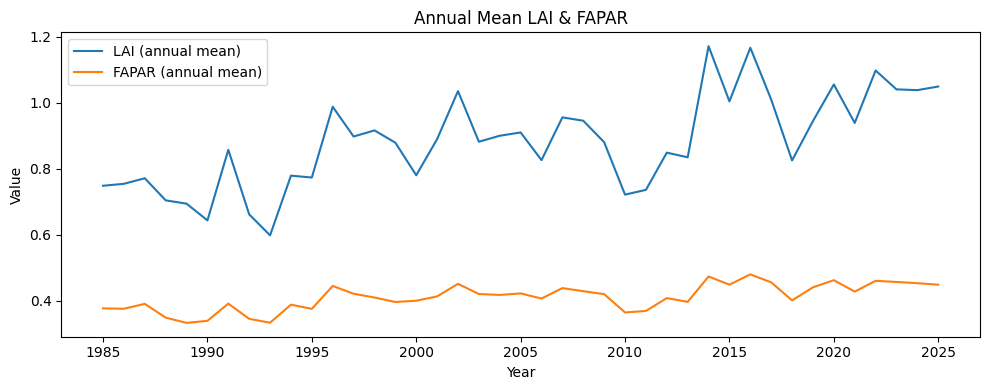

In [10]:
daily["date"] = pd.to_datetime(daily["date"], errors="coerce")
annual = (
    daily.assign(year=daily["date"].dt.year)
         .groupby("year")[["LAI","FAPAR"]]
         .mean()
         .reset_index()
)

plt.figure(figsize=(10,4))
plt.plot(annual["year"], annual["LAI"], label="LAI (annual mean)")
plt.plot(annual["year"], annual["FAPAR"], label="FAPAR (annual mean)")
plt.title("Annual Mean LAI & FAPAR")
plt.xlabel("Year"); plt.ylabel("Value")
plt.legend(); plt.tight_layout()
plt.show()


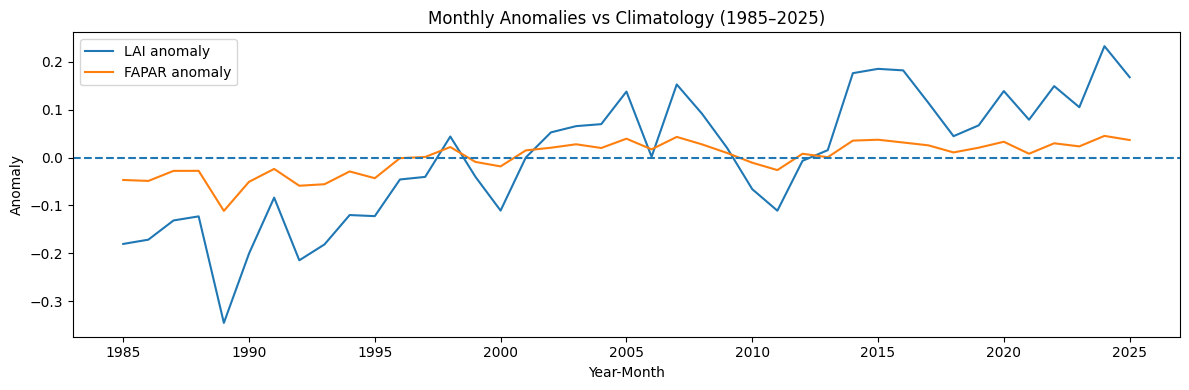

In [11]:
# Monthly climatology + anomalies (Spark) + plots
monthly_sdf = (
    sdf
    .withColumn("year",  F.year("time"))
    .withColumn("month", F.month("time"))
    .groupBy("year","month")
    .agg(
        F.mean("lai").alias("LAI"),
        F.mean("fapar").alias("FAPAR")
    )
    .orderBy("year","month")
)

# Baseline climatology by month
clim_sdf = (
    monthly_sdf
    .filter((F.col("year") >= BASELINE_START) & (F.col("year") <= BASELINE_END))
    .groupBy("month")
    .agg(
        F.mean("LAI").alias("LAI_clim"),
        F.mean("FAPAR").alias("FAPAR_clim")
    )
)

anom_sdf = (
    monthly_sdf.alias("m")
    .join(clim_sdf.alias("c"), on="month", how="left")
    .withColumn("year_month", F.to_date(F.concat_ws("-", F.col("year").cast("string"), F.col("month").cast("string"), F.lit("01"))))
    .withColumn("LAI_anom",   F.col("m.LAI")   - F.col("c.LAI_clim"))
    .withColumn("FAPAR_anom", F.col("m.FAPAR") - F.col("c.FAPAR_clim"))
    .select("year","month","year_month","LAI","FAPAR","LAI_anom","FAPAR_anom")
    .orderBy("year","month")
)

anom = anom_sdf.toPandas()

# Plot anomalies
plt.figure(figsize=(12,4))
plt.plot(anom["year_month"], anom["LAI_anom"], label="LAI anomaly")
plt.plot(anom["year_month"], anom["FAPAR_anom"], label="FAPAR anomaly")
plt.axhline(0, linestyle="--")
plt.title(f"Monthly Anomalies vs Climatology ({BASELINE_START}–{BASELINE_END})")
plt.xlabel("Year-Month")
plt.ylabel("Anomaly")
plt.legend()
plt.tight_layout()
display(plt.gcf()); plt.close()

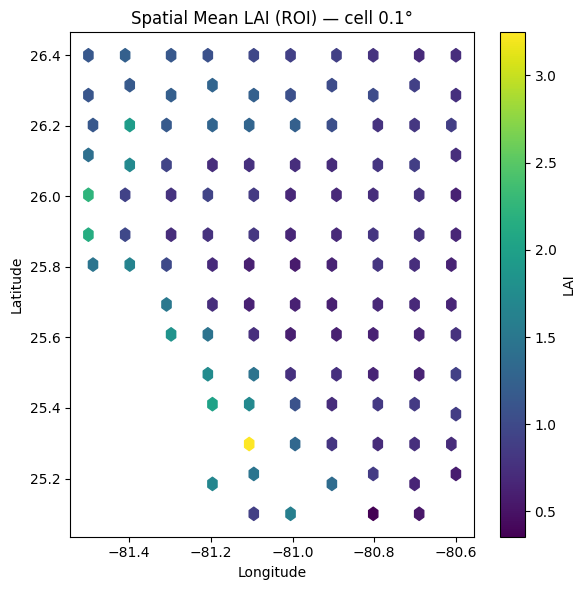

In [12]:
# Spatial grid (Spark) + hexbin map (pandas→matplotlib)
cell = F.lit(GRID_DEG)
grid_sdf = (
    sdf
    .withColumn("lat_bin", F.floor(F.col("latitude")/cell)*cell)
    .withColumn("lon_bin", F.floor(F.col("longitude")/cell)*cell)
    .groupBy("lat_bin","lon_bin")
    .agg(
        F.mean("lai").alias("LAI"),
        F.mean("fapar").alias("FAPAR")
    )
    .select(F.col("lat_bin").alias("lat"), F.col("lon_bin").alias("lon"), "LAI","FAPAR")
)

grid = grid_sdf.toPandas()

val_col = FOCUS_VAR
dfp = grid.dropna(subset=[val_col]).rename(columns={val_col:"value"})
plt.figure(figsize=(6,6))
plt.hexbin(dfp["lon"], dfp["lat"], C=dfp["value"], gridsize=40)
plt.title(f"Spatial Mean {val_col} (ROI) — cell {GRID_DEG}°")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.colorbar(label=val_col)
plt.tight_layout()
display(plt.gcf()); plt.close()